In [1]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "BTC"
connection_string = "/Users/rpsingh/Documents/MFE_PREPROGRAMS/python/Homeworks/UCB-MFE-python-preprogram/Lectures/Lecture 4/data/data.db"
events_db = "crypto_events_database"


importing packages

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/rpsingh/anaconda3/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


fetching data for a given token and date range

In [3]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'

currentFolder = os.getcwd()
homeFolder = os.path.dirname(os.path.dirname(os.path.dirname(currentFolder)))
cnxString = f'{homeFolder}/UCB-MFE-python-preprogram/Lectures/Lecture 4/data/data.db'
print (cnxString)

events_db = 'crypto_events_database'
connection = sqlite3.connect(cnxString)

/Users/rpsingh/Documents/MFE_PREPROGRAMS/python/Homeworks/UCB-MFE-python-preprogram/Lectures/Lecture 4/data/data.db


Hourly Return function

In [4]:
def retHourly(df):
    c = df.close
    ret = np.log(c/c.shift())
    return ret

Hourly Volatility function

In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

maximum drawdown function

In [6]:
def max_drawdown(df):
    c = df.close
    cummulativeMax = df.high.expanding().max()
    drawdown = c/cummulativeMax - 1
    maxDrawdown = drawdown.expanding().min()
    
    return maxDrawdown

plotting function

In [7]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection)
connection.close()
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

calculate the hourly return by timestamp

In [9]:
prices['hourly_return'] = retHourly(prices)

calculate the hourly volatility 

In [10]:
prices['hourly_volatility'] = vol_ohlc(prices)

calculate maximum drawdown up to that hour for each hour

In [11]:
prices['max_drawdown'] = max_drawdown(prices)

In [12]:
prices.head(10)

,open,high,low,close,volume,volumeUSD,token,chain,hourly_return,hourly_volatility,max_drawdown
ts,,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,NaN,-0.001416
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,-0.008560,NaN,-0.010015
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,0.014664,NaN,-0.010015
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,-0.002303,NaN,-0.010015
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,0.009175,NaN,-0.010015
2021-11-05 05:00:00,62246.59,62510.54,62117.13,62146.75,389.740623,2.426599e+07,BTC,BTC,-0.001613,NaN,-0.010015
2021-11-05 06:00:00,62146.75,62238.57,61945.62,62230.68,164.036219,1.018543e+07,BTC,BTC,0.001350,NaN,-0.010015
2021-11-05 07:00:00,62230.44,62638.59,62189.13,62216.97,260.889968,1.628503e+07,BTC,BTC,-0.000220,NaN,-0.010015
2021-11-05 08:00:00,62216.98,62524.94,62158.45,62174.32,126.796534,7.901210e+06,BTC,BTC,-0.000686,NaN,-0.010015


creating plots

In [13]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

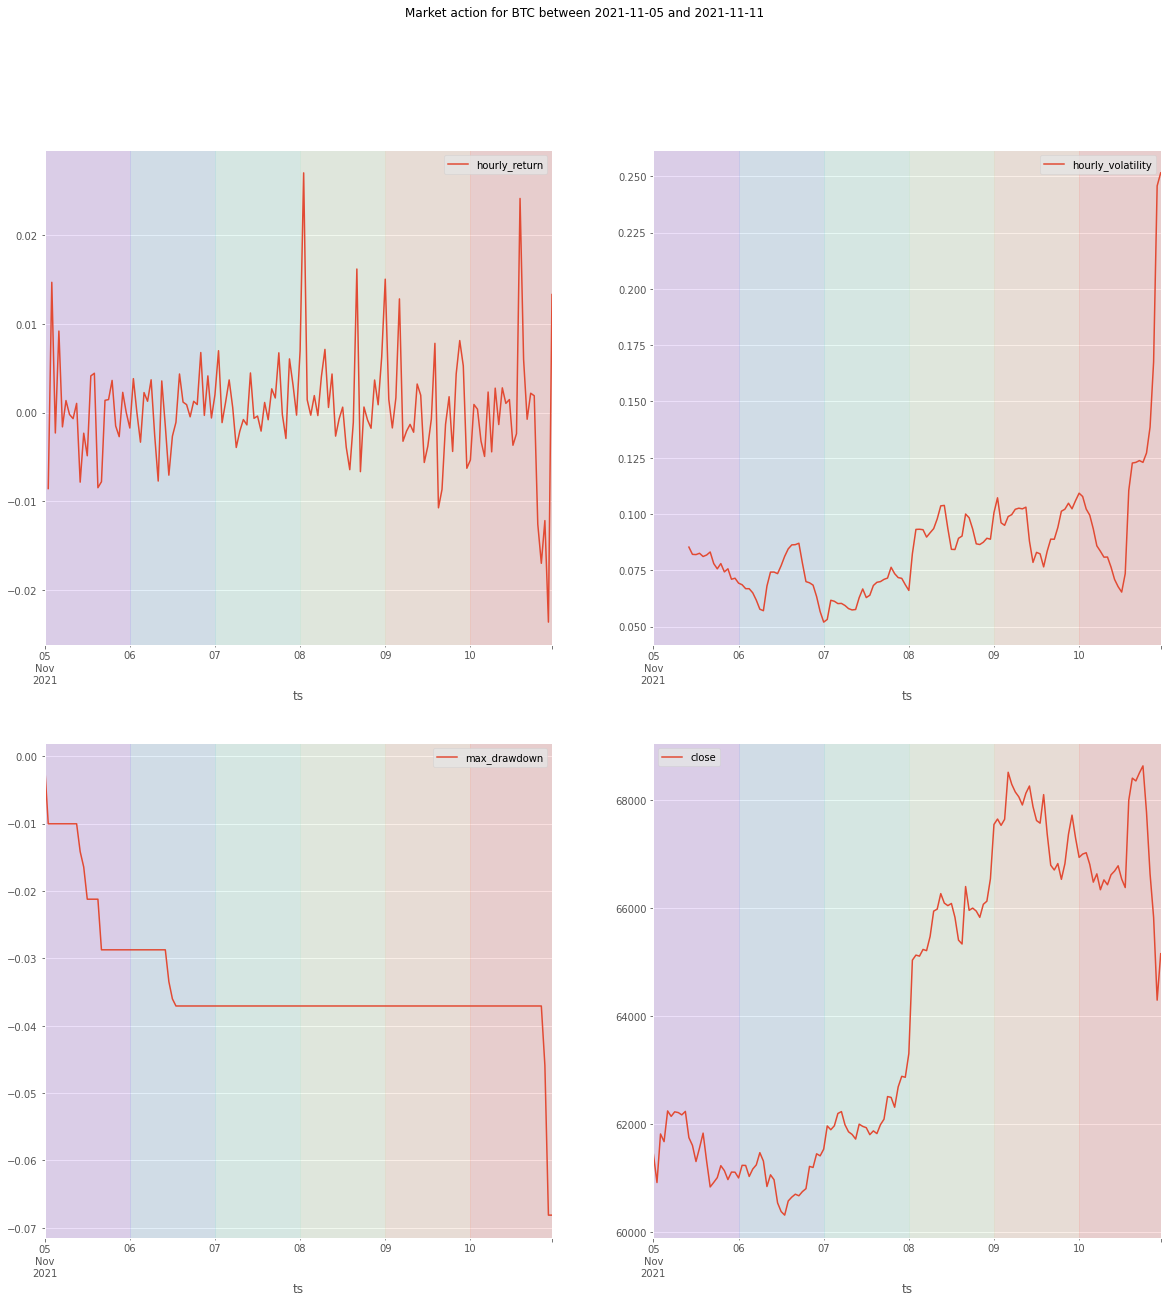

In [14]:
series_plot(prices[['hourly_return']], ax=ax[0, 0])
series_plot(prices[['hourly_volatility']],ax=ax[0, 1])
series_plot(prices[['max_drawdown']],ax=ax[1, 0])
series_plot(prices[['close']],ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

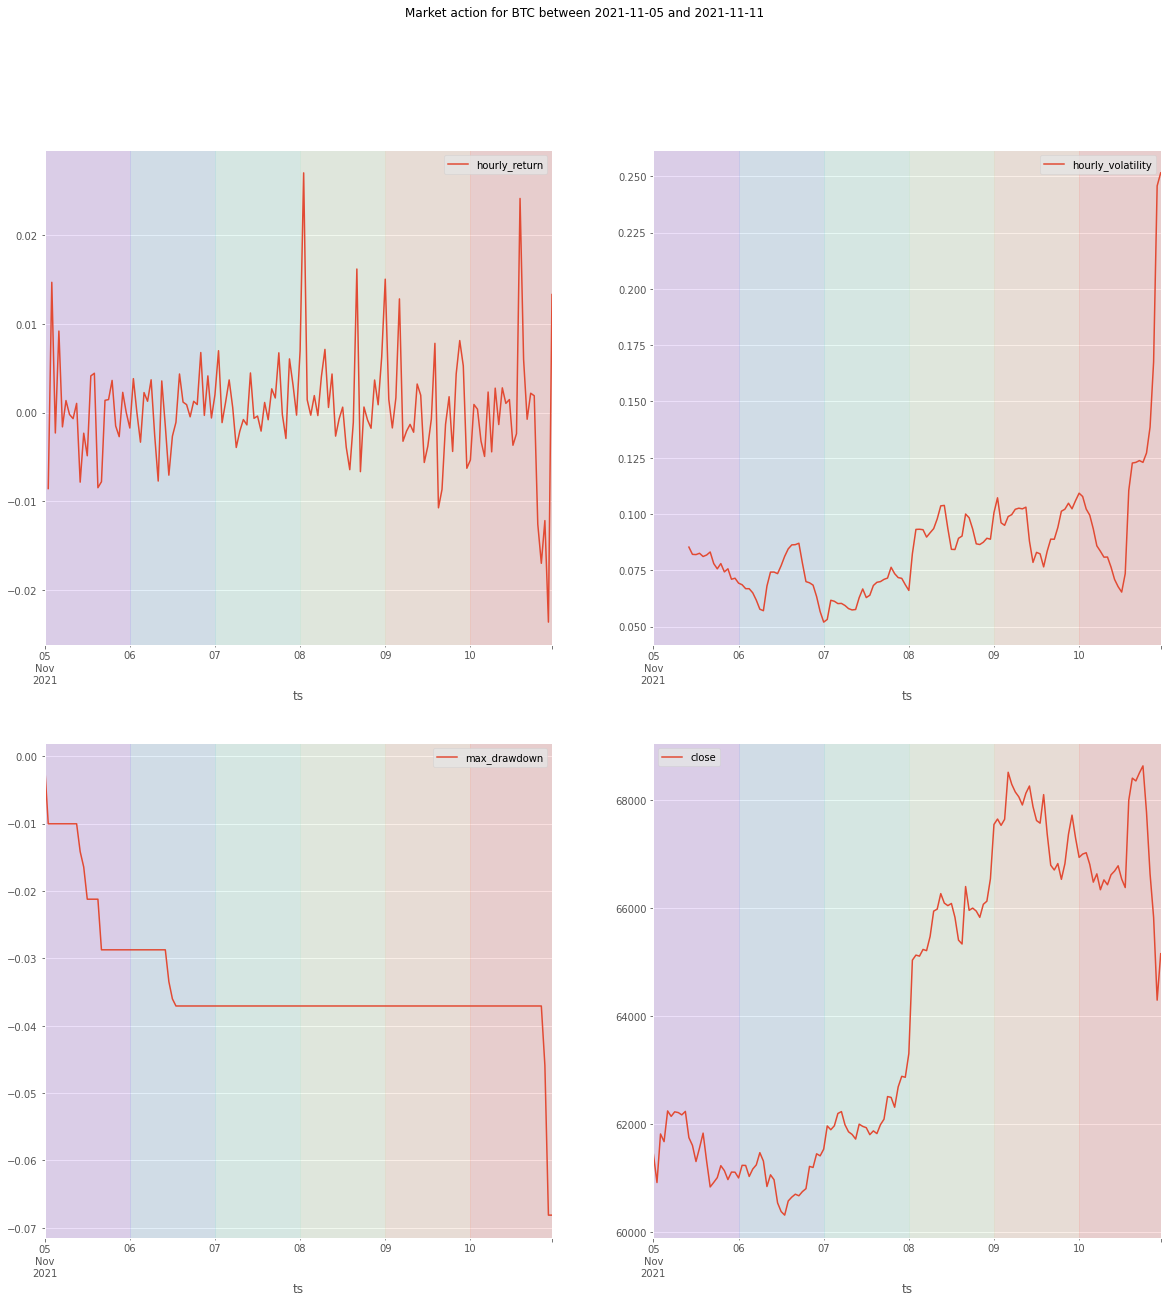

In [15]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)